# Práctica de *Machine Learning*; Marcos Gutiérrez

En este notebook se va a tratar un problema real. Es una regresión donde se tiene que predecir el precio de una estancia airbnb.
Para ello se va a utilizar un conjunto de datos extraído de airbnb.

A partir de ahí se va a llevar a cabo un análisis exploratorio y un preprocesamiento de dicha información. Analizaremos todas las variables de entrada y las trataremos de forma adecuada para poder trabajar con ellas.

Por último, se usarán algoritmos de Machine Learning para obtener modelos que una vez optimizados puedan dar los resultados de la predicción que se está buscando.

![](img/MLpipeline.png)

### RESUMEN DEL CONTENIDO:

1.- ANÁLISIS EXPLORATORIO

2.- OPTIMIZACIÓN DE DISTINTOS MODELOS

    2.1.- LASSO
    2.2.- ÁRBOL DE DECISIÓN
    2.3.- RANDOM FOREST
    2.4.- BOOSTED TREE
    2.5.- SVR
    
3.- CONCLUSIÓN

----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

In [1]:
#IMPORTAMOS LIBRERÍAS NECESARIAS

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

Como hábito de buena costumbre, para no incurrir en errores involuntarios, en primer lugar se va a dividir el dataset original en train/test.

Se trabaja únicamente con el de train y finalmente se aplica ese "entrenamiento" al bloque de test.

In [95]:
from sklearn.model_selection import train_test_split

full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')
train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 
df = pd.read_csv('./train.csv', sep=';', decimal='.')


Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


## 1.- ANÁLISIS EXPLORATORIO Y PREPROCESAMIENTO

Vamos a ver esas 89 columnas, necesitamos saber qué tipo de información disponemos.
Para ello usamos esta línea: df.columns.values.tolist()

En primer lugar, vamos a filtrar por la ciudad de Madrid. Quiero asegurarme que solo trabajamos con apartamentos de dicha ciudad.

In [96]:
# Obtengo los índices de las columnas que no pertenecen a la ciudad de Madrid.
indexNames = df[ df['City'] != 'Madrid' ].index
# Borro esas filas del dataframe (para filas axis=0 por defecto)
df.drop(indexNames , inplace=True)

#esta columna también se puede borrar ya que después de este filtrado tiene el mismo valor para todas las filas
df.drop(['City'], axis=1, inplace=True)

df.shape

(10567, 88)

Ahora usamos los siguientes comandos para ir viendo una por una cada una de nuestras features y decidir si los vamos a usar en nuestro entrenamiento o si podemos prescindir de ellas:
    - df['xxxxx'].describe()
    - df['xxxxx'].value_counts()
    
Podemos destacar las siguientes agrupaciones de columnas:
    - Columnas relacionadas con ID: considero que es información que identifica cada propiedad de forma singular y unívoca y no guarda ninguna relación con otras propiedades ni sus precios. Podemos eliminarlas de nuestro dataset.
    ['ID','Scrape ID','Last Scraped','Host ID','Calendar last Scraped']
    - Columnas relacionas con URLs: son URLs que nos direccionan a otro sitio web e incluyen fotos. En este caso no vamos a hacer tratamiento de imagen, así que podemos eliminarlas.
    ['Listing Url','Thumbnail Url','Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url',]
    - Columnas descriptivas: Son columnas de tipo objeto. Contienen mucha literatura y la información es redundante con otras más específicas. Son resúmenes detallando el tipo de propiedad y sus características (número de habitaciones, calle, barrio, etc). Se da el caso también que el número de entradas únicas para cada una de estas columnas es muy parecido al número total, por lo que además es muy complicado hacer agrupaciones o clústers. Por tanto podemos eliminarlas.
    ['Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access','Interaction','House Rules','Host Name','Host About','Street']
    - Columnas que hacen referencia a Madrid, España: Ya hemos filtrado por la ciudad de Madrid, así que la información relacionada con País, Estado o similar no nos aporta nada. Añadimos también la columna Geolocation que está duplicada con Latitude y Longitude. Podemos eliminarlas del dataset.
    ['Host Location','State','Market','Smart Location','Country Code','Country','Geolocation']
    - Columnas relacionadas con el precio: son columnas que nos hacen trampa a la hora de predecir el precio. Las eliminamos del dataset.
    ['Weekly Price','Monthly Price']
    - Otras columnas que no aportan valor: aquí agrupamos columnas donde todos los valores son none, están vacías o solo tienen valores un número de entradas menor que el 5% del total del dataset.
    ['Host Acceptance Rate','Experiences Offered','Has Availability','License','Jurisdiction Names','Square Feet']

In [97]:
df.drop(['ID','Scrape ID','Last Scraped','Host ID','Calendar last Scraped','Listing Url','Thumbnail Url',
         'Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url',
        'Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access',
         'Interaction','House Rules','Host Name','Host About','Street','Host Location','State','Market',
         'Smart Location','Country Code','Country','Geolocation','Weekly Price','Monthly Price',
         'Host Acceptance Rate','Experiences Offered','Has Availability','License','Jurisdiction Names','Square Feet'], 
        axis=1, inplace=True)

df.shape

(10567, 47)

Ahora nos centramos en la variable objetivo: Price. Vamos a ver su histograma y sus datos más relevantes:

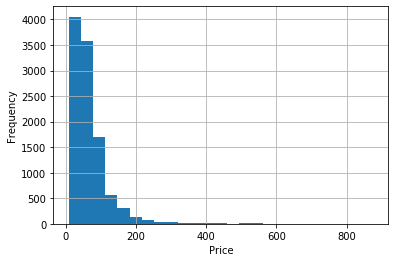

count    10559.00000
mean        66.18515
std         56.16416
min          9.00000
25%         31.00000
50%         53.00000
75%         80.00000
max        875.00000
Name: Price, dtype: float64

In [86]:
df['Price'].plot.hist(bins=25, grid = True)
plt.xlabel('Price')

plt.show()

df['Price'].describe()

A la vista de los resultados consideramos que más de 400€ es outlier y hay 8 entradas en las que hay que imputar valores. Lo haremos usando la media.
Además se aprecia que tiene una distribución logarítmica, por lo que vamos a aplicarle también dicha transformación

In [98]:
MeanPriceTrain = df['Price'].mean()
df['Price'].fillna(MeanPriceTrain, inplace=True)

Price_filter = df['Price'] <= 400
filtered_df = df[Price_filter]

filtered_df['Price'] = filtered_df['Price'].apply(lambda x: np.log10(x))

filtered_df.shape

(10523, 47)

Vamos a trabajar con las columnas que sabemos son de tipo fecha. En primer lugar le damos formato de año-mes-día y luego lo restamos a 2017, que lo tomamos como referencia de cuando se creó el dataset. 
De esta forma obtenemos columnas de tipo float cuyo valor mínimo será 0 (indica que es muy reciente) y el máximo será el número de años de diferencia entre 2017 y el evento concreto (Host since o First/Last Review).

In [99]:
filtered_df['Host Since'] = pd.to_datetime(filtered_df['Host Since'], format="%Y-%m-%d")
filtered_df['First Review'] = pd.to_datetime(filtered_df['First Review'], format="%Y-%m-%d")
filtered_df['Last Review'] = pd.to_datetime(filtered_df['Last Review'], format="%Y-%m-%d")

filtered_df['Host Since'] = filtered_df['Host Since'].apply(lambda x: 2017 - x.year)
filtered_df['First Review'] = filtered_df['First Review'].apply(lambda x: 2017 - x.year)
filtered_df['Last Review'] = filtered_df['Last Review'].apply(lambda x: 2017 - x.year)
filtered_df.head()

,Host Since,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,...,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Features
0,2.0,within a few hours,100.0,Jerónimos,2.0,2.0,"email,phone,reviews,work_email",Jerónimos,Jerónimos,Retiro,...,9.0,10.0,10.0,10.0,10.0,9.0,moderate,2.0,0.50,"Host Has Profile Pic,Is Location Exact,Require..."
1,1.0,within an hour,100.0,NaN,1.0,1.0,"email,phone,reviews,jumio,offline_government_i...",NaN,Sol,Centro,...,9.0,9.0,10.0,10.0,10.0,10.0,flexible,1.0,2.43,"Host Has Profile Pic,Host Identity Verified,Re..."
2,1.0,within an hour,100.0,Carabanchel,16.0,16.0,"email,phone,facebook,google,reviews,jumio,gove...",Carabanchel,Vista Alegre,Carabanchel,...,NaN,NaN,NaN,NaN,NaN,NaN,moderate,16.0,NaN,"Host Has Profile Pic,Host Identity Verified,Is..."
3,3.0,within a few hours,100.0,Justicia,114.0,114.0,"email,phone,reviews,work_email",NaN,Embajadores,Centro,...,NaN,NaN,NaN,NaN,NaN,NaN,strict,97.0,NaN,"Host Has Profile Pic,Requires License"
4,5.0,within an hour,100.0,Gaztambide,2.0,2.0,"email,phone,reviews,jumio",Gaztambide,Gaztambide,Chamberí,...,9.0,9.0,9.0,10.0,9.0,9.0,strict,2.0,2.08,"Host Has Profile Pic,Host Identity Verified,Is..."


Vamos a ir imputando valores para completar nuestro dataset. Usamos la siguiente línea para ver donde hay campos vacíos: filtered_df.isnull().any(), y esta otra para ver el detalle de los valores: filtered_df['xxxx'].describe()

In [100]:
#variables categóricas donde tomamos la moda para los valores que faltan.
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
ModeHSTrain = filtered_df['Host Since'].mode()[0]
ModeHLCTrain = filtered_df['Host Listings Count'].mode()[0]
ModeHTLCTrain = filtered_df['Host Total Listings Count'].mode()[0]
ModeBathroomsTrain = filtered_df['Bathrooms'].mode()[0]
ModeBedroomsTrain = filtered_df['Bedrooms'].mode()[0]
ModeBedsTrain = filtered_df['Beds'].mode()[0]

filtered_df['Host Since'].fillna(ModeHSTrain, inplace=True)
filtered_df['Host Listings Count'].fillna(ModeHLCTrain, inplace=True)
filtered_df['Host Total Listings Count'].fillna(ModeHTLCTrain, inplace=True)
filtered_df['Bathrooms'].fillna(ModeBathroomsTrain, inplace=True)
filtered_df['Bedrooms'].fillna(ModeBedroomsTrain, inplace=True)
filtered_df['Beds'].fillna(ModeBedsTrain, inplace=True)

#variables lineales donde tomamos la media para los valores que faltan
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
MeanRSRatingTrain = filtered_df['Review Scores Rating'].mean()
MeanRSAccuracy = filtered_df['Review Scores Accuracy'].mean()
MeanRSCleanliness = filtered_df['Review Scores Cleanliness'].mean()
MeanRSCheckin = filtered_df['Review Scores Checkin'].mean()
MeanRSCommunication = filtered_df['Review Scores Communication'].mean()
MeanRSLocation = filtered_df['Review Scores Location'].mean()
MeanRSValue = filtered_df['Review Scores Value'].mean()

filtered_df['Review Scores Rating'].fillna(MeanRSRatingTrain, inplace=True)
filtered_df['Review Scores Accuracy'].fillna(MeanRSAccuracy, inplace=True)
filtered_df['Review Scores Cleanliness'].fillna(MeanRSCleanliness, inplace=True)
filtered_df['Review Scores Checkin'].fillna(MeanRSCheckin, inplace=True)
filtered_df['Review Scores Communication'].fillna(MeanRSCommunication, inplace=True)
filtered_df['Review Scores Location'].fillna(MeanRSLocation, inplace=True)
filtered_df['Review Scores Value'].fillna(MeanRSValue, inplace=True)

#los vacíos los consideramos como desconocidos
filtered_df['Host Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df['Host Verifications'].fillna('Unknown', inplace=True)
filtered_df['Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df['Zipcode'].fillna('Unknown', inplace=True)
filtered_df['Amenities'].fillna('Unknown', inplace=True)
filtered_df['First Review'].fillna('Unknown', inplace=True)
filtered_df['Last Review'].fillna('Unknown', inplace=True)

#consideramos que donde falta un valor es porque no existe, es decir, no hay respuesta o la tasa es 0€
filtered_df['Host Response Time'].fillna('No response', inplace=True)
filtered_df['Host Response Rate'].fillna(0, inplace=True)
filtered_df['Security Deposit'].fillna(0, inplace=True)
filtered_df['Cleaning Fee'].fillna(0, inplace=True)
filtered_df['Reviews per Month'].fillna(0, inplace=True)

Ahora vamos a ver las columnas que todavía no son numéricas. La idea es transformarlas o codificarlas con un MeanEncoder. Utilizamos el comando filtered_df.dtypes para comprobarlo.

También añadimos nuevas variables, como la relación Bedrooms x Bathrooms.

In [101]:
#transformaciones contando palabras. es algo muy sencillo, queda pendiente mejorarlo con técnicas NLP en el futuro
filtered_df['Amenities'] = filtered_df['Amenities'].apply(lambda x: len(str(x).split(',')))
filtered_df['Host Verifications'] = filtered_df['Host Verifications'].apply(lambda x: len(str(x).split(',')))
filtered_df['Features'] = filtered_df['Features'].apply(lambda x: len(str(x).split(',')))

categorical = ['Host Response Time', 'Host Neighbourhood', 'Neighbourhood','Neighbourhood Cleansed',
               'Neighbourhood Group Cleansed','Zipcode','Property Type','Room Type','Bed Type',
               'Calendar Updated','First Review','Last Review','Cancellation Policy']

# En train creamos un dict para usarlo después en test
mean_map = {}
for c in categorical:
    mean = filtered_df.groupby(c)['Price'].mean()
    filtered_df[c] = filtered_df[c].map(mean)    
    mean_map[c] = mean
    
#nueva variable
filtered_df['Bed_Bath_Rooms'] = filtered_df['Bedrooms']*filtered_df['Bathrooms']

Ahora vamos a visulizar nuestras variables. Nos vamos a ayudar del histograma de cada una de ellas para ver qué distribución tienen y sus valores. Se puede ver por ejemplo como Price ha variado a una distribución gaussiana después de la transformación logarítmica que le hemos aplicado.

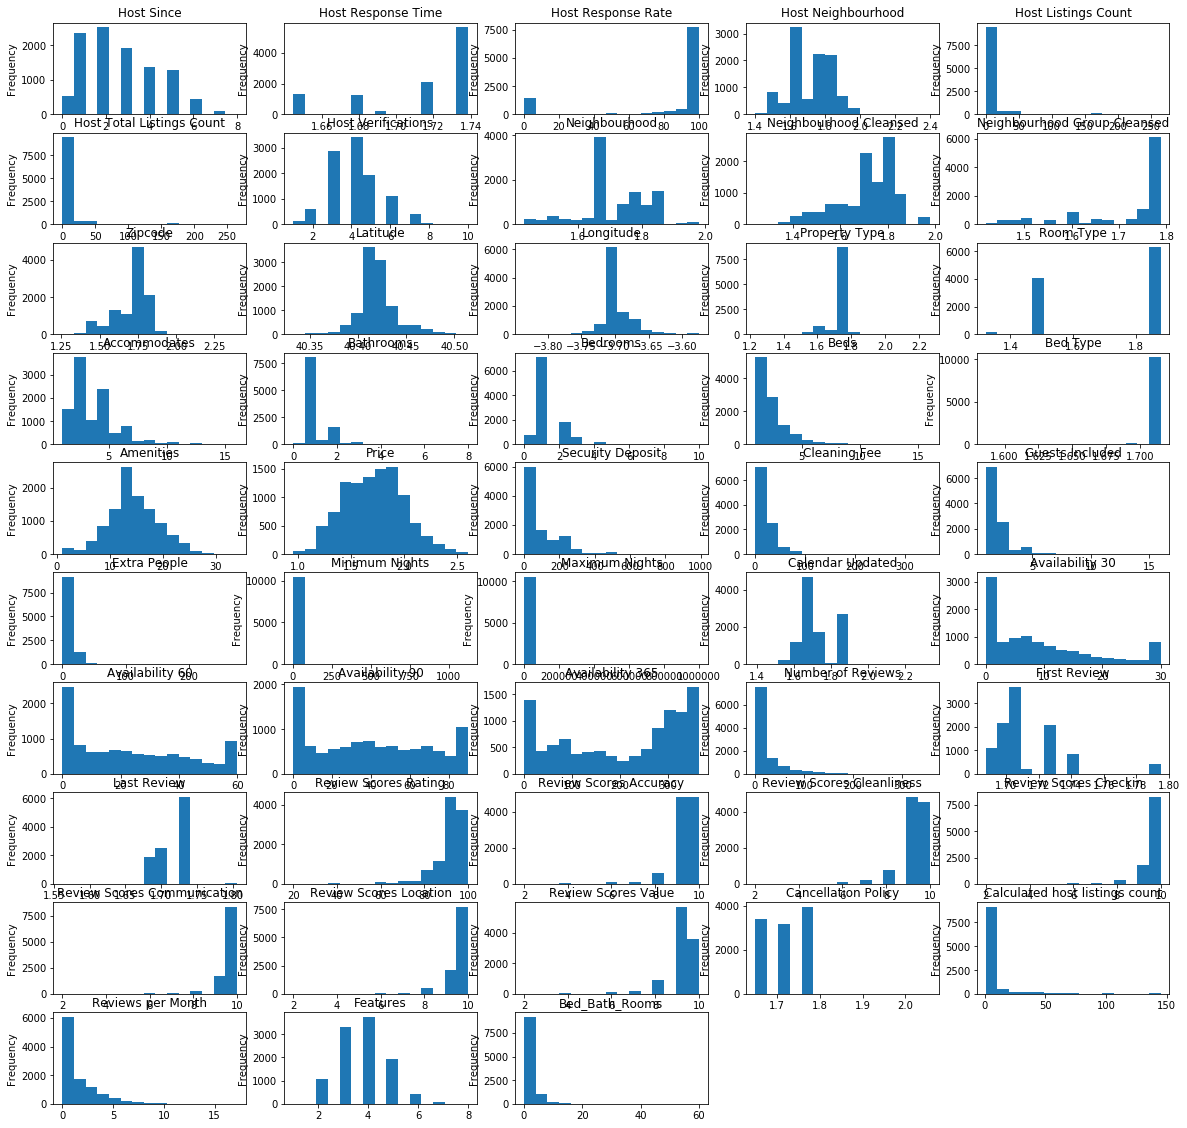

In [102]:
# Pintamos histogramas para cada feature
plt.figure(figsize=(20,30))

for i,feature in enumerate(filtered_df):
    plt.subplot(15,5,i+1)   
    filtered_df[feature].plot.hist(bins=15)
    plt.title(feature)

plt.show()

Según los histogramas vamos a aplicar una transformación logarítmica a las siguientes variables:

finalmente no lo ejecuto porque el logaritmo no nos devuelve una distribución gaussiana. Se queda prácticamente igual.

filtered_df['Log_Beds'] = filtered_df['Beds'].apply(lambda x: np.log10(x))

filtered_df['Log_Guests Included'] = filtered_df['Guests Included'].apply(lambda x: np.log10(x))


plt.subplot(1,2,1)   
filtered_df['Beds'].plot.hist(bins=15)
plt.subplot(1,2,2)
filtered_df['Log_Beds'].plot.hist(bins=25, grid = True)

plt.show()


Ahora tenemos todas nuestras columnas en formato numérico y sin entradas vacías. Vamos a ver en primer lugar la correlación entre ellas.

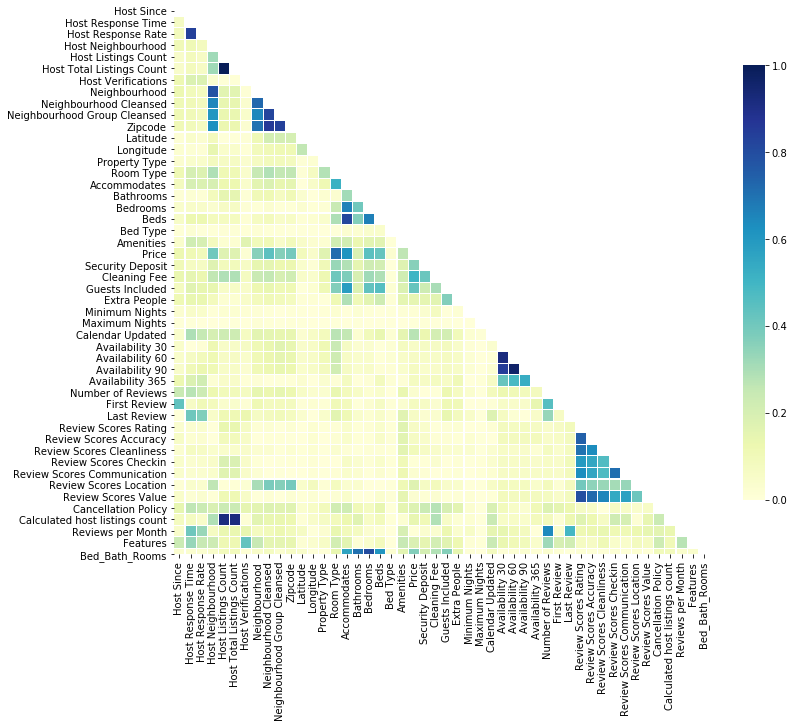

In [103]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(filtered_df.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Se trata de una matriz muy grande porque tenemos muchas variables de entrada. Vamos a hacer un poco de zoom en aquellas que tienen una correlación superior al 0.9

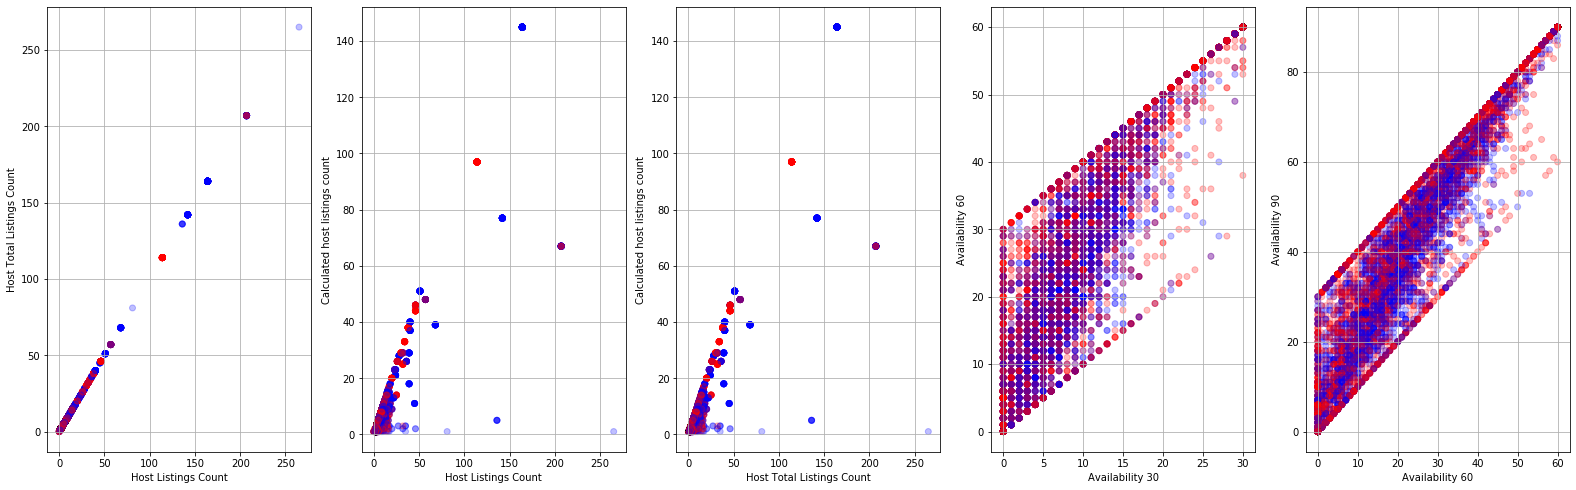

5

In [104]:
# Create correlation matrix
corr_matrix = filtered_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
pairs = np.where(upper>0.90)
fx = filtered_df.columns[pairs[0]]
fy =  filtered_df.columns[pairs[1]]

i=1
plt.figure(figsize=(22,20))
for f1,f2 in zip(fx,fy):
    
    plt.subplot(3,5,i)
    
    plt.scatter(filtered_df[f1],filtered_df[f2], c=filtered_df['Price'],cmap=cm_bright, alpha=0.25)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.grid()
    plt.tight_layout()
    
    i+=1
    
plt.show()
len(pairs[0])

Viendo estos resultados vamos a prescindir de las siguientes columnas: Host Listings Count, Host Total Listings Count, Availability 30 y Availability 90

In [105]:
filtered_df.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 90'], 
        axis=1, inplace=True)

#modifico el orden de las columnas para tener la variable objetivo (Price) la primera de todas.
cols = filtered_df.columns.tolist()
cols = cols[19:20] + cols[0:19] + cols [20:]
filtered_df = filtered_df[cols]

print(filtered_df.shape)
filtered_df.head()

(10523, 44)


,Price,Host Since,Host Response Time,Host Response Rate,Host Neighbourhood,Host Verifications,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Zipcode,...,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Features,Bed_Bath_Rooms
0,1.778151,2.0,1.714674,100.0,1.777984,4,1.862243,1.870709,1.715954,1.828019,...,10.00000,10.000000,10.000000,10.000000,9.00000,1.721732,2.0,0.50,3,1.0
1,1.698970,1.0,1.738618,100.0,1.650428,6,1.665877,1.855905,1.779878,1.748494,...,9.00000,10.000000,10.000000,10.000000,10.00000,1.647716,1.0,2.43,4,1.0
2,1.000000,1.0,1.738618,100.0,1.504347,7,1.495580,1.433458,1.480933,1.433262,...,9.32033,9.625986,9.648007,9.546238,9.20762,1.721732,16.0,0.00,5,1.5
3,1.477121,3.0,1.714674,100.0,1.738522,4,1.665877,1.711917,1.779878,1.748494,...,9.32033,9.625986,9.648007,9.546238,9.20762,1.765223,97.0,0.00,2,3.0
4,1.505150,5.0,1.738618,100.0,1.610016,4,1.638195,1.640189,1.752802,1.716663,...,9.00000,9.000000,10.000000,9.000000,9.00000,1.765223,2.0,2.08,4,1.0


## 2.- OPTIMIZACIÓN DE DISTINTOS MODELOS


### 2.1. Lasso

El primer paso es dividir nuestro conjunto de datos en X (variables independientes de entrada) e y (variable dependiente). Luego hacemos cross-validation para ver el valor óptimo de alpha (usamos GridSearch).
Y por último aplicamos ese modelo al conjunto de test para obtener los resultados finales. De la comparación de estos valores predichos con los valores reales se obtiene el MSE y el RMSE que nos sirve para evaluar y comparar los distintos modelos que se utilizan en la práctica.

In [189]:
from sklearn import preprocessing
data = filtered_df.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = cols[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

best mean cross-validation score: 0.731
best parameters: {'alpha': 0.000379269019073225}


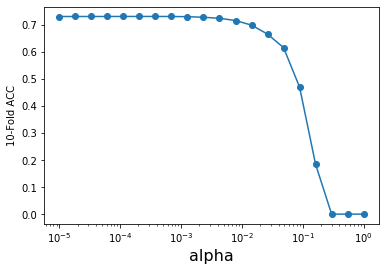

In [180]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-5, 0, 20)
param_grid = {'alpha': alpha_vector }
gridLasso = GridSearchCV(Lasso(), param_grid=param_grid, cv = 10)
gridLasso.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(gridLasso.best_score_))
print("best parameters: {}".format(gridLasso.best_params_))

scores = np.array(gridLasso.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold ACC')
plt.show()

Ahora cargamos el conjunto de test, lo transformamos de la misma manera que hemos hecho con el de train y evaluamos los resultados

In [190]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# aplicarle LAS MISMAS transformaciones que hayáis hecho en train 
#filtro Madrid
indexNames = df_test[df_test['City'] != 'Madrid' ].index
df_test.drop(indexNames , inplace=True)
df_test.drop(['City'], axis=1, inplace=True)

#drop general
df_test.drop(['ID','Scrape ID','Last Scraped','Host ID','Calendar last Scraped','Listing Url','Thumbnail Url',
         'Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url',
        'Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access',
         'Interaction','House Rules','Host Name','Host About','Street','Host Location','State','Market',
         'Smart Location','Country Code','Country','Geolocation','Weekly Price','Monthly Price',
         'Host Acceptance Rate','Experiences Offered','Has Availability','License','Jurisdiction Names','Square Feet'], 
        axis=1, inplace=True)
#price
df_test['Price'].fillna(MeanPriceTrain, inplace=True)
Price_filter = df_test['Price'] <= 400
filtered_df_test = df_test[Price_filter]
filtered_df_test['Price'] = filtered_df_test['Price'].apply(lambda x: np.log10(x))

#fechas
filtered_df_test['Host Since'] = pd.to_datetime(filtered_df_test['Host Since'], format="%Y-%m-%d")
filtered_df_test['First Review'] = pd.to_datetime(filtered_df_test['First Review'], format="%Y-%m-%d")
filtered_df_test['Last Review'] = pd.to_datetime(filtered_df_test['Last Review'], format="%Y-%m-%d")
filtered_df_test['Host Since'] = filtered_df_test['Host Since'].apply(lambda x: 2017 - x.year)
filtered_df_test['First Review'] = filtered_df_test['First Review'].apply(lambda x: 2017 - x.year)
filtered_df_test['Last Review'] = filtered_df_test['Last Review'].apply(lambda x: 2017 - x.year)

#variables categóricas donde tomamos la moda para los valores que faltan.
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Host Since'].fillna(ModeHSTrain, inplace=True)
filtered_df_test['Host Listings Count'].fillna(ModeHLCTrain, inplace=True)
filtered_df_test['Host Total Listings Count'].fillna(ModeHTLCTrain, inplace=True)
filtered_df_test['Bathrooms'].fillna(ModeBathroomsTrain, inplace=True)
filtered_df_test['Bedrooms'].fillna(ModeBedroomsTrain, inplace=True)
filtered_df_test['Beds'].fillna(ModeBedsTrain, inplace=True)

#variables lineales donde tomamos la media para los valores que faltan
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Review Scores Rating'].fillna(MeanRSRatingTrain, inplace=True)
filtered_df_test['Review Scores Accuracy'].fillna(MeanRSAccuracy, inplace=True)
filtered_df_test['Review Scores Cleanliness'].fillna(MeanRSCleanliness, inplace=True)
filtered_df_test['Review Scores Checkin'].fillna(MeanRSCheckin, inplace=True)
filtered_df_test['Review Scores Communication'].fillna(MeanRSCommunication, inplace=True)
filtered_df_test['Review Scores Location'].fillna(MeanRSLocation, inplace=True)
filtered_df_test['Review Scores Value'].fillna(MeanRSValue, inplace=True)

#los vacíos los consideramos como desconocidos
filtered_df_test['Host Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Host Verifications'].fillna('Unknown', inplace=True)
filtered_df_test['Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Zipcode'].fillna('Unknown', inplace=True)
filtered_df_test['Amenities'].fillna('Unknown', inplace=True)
filtered_df_test['First Review'].fillna('Unknown', inplace=True)
filtered_df_test['Last Review'].fillna('Unknown', inplace=True)

#consideramos que donde falta un valor es porque no existe, es decir, no hay respuesta o la tasa es 0€
filtered_df_test['Host Response Time'].fillna('No response', inplace=True)
filtered_df_test['Host Response Rate'].fillna(0, inplace=True)
filtered_df_test['Security Deposit'].fillna(0, inplace=True)
filtered_df_test['Cleaning Fee'].fillna(0, inplace=True)
filtered_df_test['Reviews per Month'].fillna(0, inplace=True)

#transformaciones contando palabras. es algo muy sencillo, queda pendiente mejorarlo con técnicas NLP en el futuro
filtered_df_test['Amenities'] = filtered_df_test['Amenities'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Host Verifications'] = filtered_df_test['Host Verifications'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Features'] = filtered_df_test['Features'].apply(lambda x: len(str(x).split(',')))

# MeanEncoder
for c in categorical:
    filtered_df_test[c] = filtered_df_test[c].map(mean_map[c])

#creación nuevas variables
filtered_df_test['Bed_Bath_Rooms'] = filtered_df_test['Bedrooms']*filtered_df_test['Bathrooms']

#eliminamos vaiables con correlación muy alta
filtered_df_test.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 90'], 
        axis=1, inplace=True)

#colocamos la variable objetivo al principio
cols = filtered_df_test.columns.tolist()
cols = cols[19:20] + cols[0:19] + cols [20:]
filtered_df_test = filtered_df_test[cols]

#los valores vacíos de test los completo con la moda de train
filtered_df_test['Host Neighbourhood'].fillna(filtered_df['Host Neighbourhood'].mode()[0], inplace=True)
filtered_df_test['Zipcode'].fillna(filtered_df['Zipcode'].mode()[0], inplace=True)
filtered_df_test['Property Type'].fillna(filtered_df['Property Type'].mode()[0], inplace=True)
filtered_df_test['Calendar Updated'].fillna(filtered_df['Calendar Updated'].mode()[0], inplace=True)

data_test = filtered_df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = filtered_df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

Antes de seguir hago una comprobación con los datos de test a ver si se han transformado de forma correcta. Para ello volvemos a usar estos comandos y vemos si quedan valores por imputar: filtered_df_test.isnull().any()

In [191]:
from sklearn.metrics import mean_squared_error

alpha_optimo = gridLasso.best_params_['alpha']*100
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

print("Train: ",lasso.score(XtrainScaled,y_train))
print("Test: ",lasso.score(XtestScaled,y_test))

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)

#deshacemos la transformación logarítmica (importante hacerlo con las predicciones y con los datos de train/test)
ytrainLasso = pd.DataFrame(ytrainLasso).apply(lambda x: 10**(x))
ytestLasso = pd.DataFrame(ytestLasso).apply(lambda x: 10**(x))
y_train = pd.DataFrame(y_train).apply(lambda x: 10**(x))
y_test = pd.DataFrame(y_test).apply(lambda x: 10**(x))

#calculamos el MSE y el RMSE para train y test
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

print("alpha: {}".format(alpha_optimo))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

Train:  0.6435288079580088
Test:  0.6269218320860805
MSE Modelo Lasso (train): 1.15e+03
MSE Modelo Lasso (test) : 1.17e+03
RMSE Modelo Lasso (train): 34
RMSE Modelo Lasso (test) : 34.3
alpha: 0.0379269019073225
Host Since 0.0
Host Response Time -0.0
Host Response Rate -0.0
Host Neighbourhood 0.0037581575041198494
Host Verifications -0.0
Neighbourhood 0.0
Neighbourhood Cleansed 0.03681890454911775
Neighbourhood Group Cleansed 0.0
Zipcode 0.0
Latitude 0.0
Longitude 0.0
Property Type 0.0
Room Type 0.11461774525750897
Accommodates 0.045966721464161066
Bathrooms 0.0
Bedrooms 0.02120343677121619
Beds 0.0
Bed Type 0.0
Amenities 0.0
Security Deposit 0.0
Cleaning Fee 0.023384165846902456
Guests Included 0.0
Extra People 0.0
Minimum Nights -0.0
Maximum Nights 0.0
Calendar Updated 0.0
Availability 60 0.0
Availability 365 0.0
Number of Reviews -0.0
First Review 0.0
Last Review -0.0
Review Scores Rating 0.0
Review Scores Accuracy 0.0
Review Scores Cleanliness 0.0
Review Scores Checkin 0.0
Review Sc

En esta última ejecución hemos usado alpha_óptimo multiplicado por 100 y en la imagen de abajo se pueden comparar los resultados con alpha_óptimo y alpha_optimo x 10.

Se observa cómo a medida que aumenta alfa el modelo se simplifica y se anulan coeficientes, es decir, se podrían quitar variables de entrada. Esto hace que la interpretabilidad del modelo cada vez sea más sencilla. Sin embargo se pierde precisión y el error aumenta.

Aplicación a este ejemplo:
Con un alfa (el óptimo) de 0.000379 tenemos 41 variables de entrada que influyen y un error medio de 28.5€ en el conjunto de test.
Aumentamos alfa a 0.0379 y ahora solo depende de 7 variables pero el error medio ha subido a 34.3€ en test.

![](img/lasso_alpha_optimo.png)

### 2.2. Árbol de decisión

El proceso es igual que en el modelo anterior: separación X/y, validación cruzada, aplicación en test y comprobación de resultados.

In [203]:
from sklearn import preprocessing
data = filtered_df.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = cols[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

best mean cross-validation score: 0.728
best parameters: {'max_depth': 7}


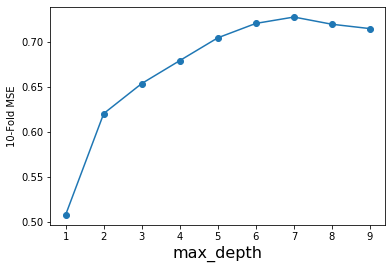

In [193]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Tu código aquí
maxDepth = range(1,10)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold ACC')
#plt.ylim((-1, 0))
plt.show()

Ahora cargamos el conjunto de test, lo transformamos de la misma manera que hemos hecho con el de train y evaluamos los resultados

In [204]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# aplicarle LAS MISMAS transformaciones que hayáis hecho en train 
#filtro Madrid
indexNames = df_test[df_test['City'] != 'Madrid' ].index
df_test.drop(indexNames , inplace=True)
df_test.drop(['City'], axis=1, inplace=True)

#drop general
df_test.drop(['ID','Scrape ID','Last Scraped','Host ID','Calendar last Scraped','Listing Url','Thumbnail Url',
         'Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url',
        'Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access',
         'Interaction','House Rules','Host Name','Host About','Street','Host Location','State','Market',
         'Smart Location','Country Code','Country','Geolocation','Weekly Price','Monthly Price',
         'Host Acceptance Rate','Experiences Offered','Has Availability','License','Jurisdiction Names','Square Feet'], 
        axis=1, inplace=True)
#price
df_test['Price'].fillna(MeanPriceTrain, inplace=True)
Price_filter = df_test['Price'] <= 400
filtered_df_test = df_test[Price_filter]
filtered_df_test['Price'] = filtered_df_test['Price'].apply(lambda x: np.log10(x))

#fechas
filtered_df_test['Host Since'] = pd.to_datetime(filtered_df_test['Host Since'], format="%Y-%m-%d")
filtered_df_test['First Review'] = pd.to_datetime(filtered_df_test['First Review'], format="%Y-%m-%d")
filtered_df_test['Last Review'] = pd.to_datetime(filtered_df_test['Last Review'], format="%Y-%m-%d")
filtered_df_test['Host Since'] = filtered_df_test['Host Since'].apply(lambda x: 2017 - x.year)
filtered_df_test['First Review'] = filtered_df_test['First Review'].apply(lambda x: 2017 - x.year)
filtered_df_test['Last Review'] = filtered_df_test['Last Review'].apply(lambda x: 2017 - x.year)

#variables categóricas donde tomamos la moda para los valores que faltan.
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Host Since'].fillna(ModeHSTrain, inplace=True)
filtered_df_test['Host Listings Count'].fillna(ModeHLCTrain, inplace=True)
filtered_df_test['Host Total Listings Count'].fillna(ModeHTLCTrain, inplace=True)
filtered_df_test['Bathrooms'].fillna(ModeBathroomsTrain, inplace=True)
filtered_df_test['Bedrooms'].fillna(ModeBedroomsTrain, inplace=True)
filtered_df_test['Beds'].fillna(ModeBedsTrain, inplace=True)

#variables lineales donde tomamos la media para los valores que faltan
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Review Scores Rating'].fillna(MeanRSRatingTrain, inplace=True)
filtered_df_test['Review Scores Accuracy'].fillna(MeanRSAccuracy, inplace=True)
filtered_df_test['Review Scores Cleanliness'].fillna(MeanRSCleanliness, inplace=True)
filtered_df_test['Review Scores Checkin'].fillna(MeanRSCheckin, inplace=True)
filtered_df_test['Review Scores Communication'].fillna(MeanRSCommunication, inplace=True)
filtered_df_test['Review Scores Location'].fillna(MeanRSLocation, inplace=True)
filtered_df_test['Review Scores Value'].fillna(MeanRSValue, inplace=True)

#los vacíos los consideramos como desconocidos
filtered_df_test['Host Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Host Verifications'].fillna('Unknown', inplace=True)
filtered_df_test['Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Zipcode'].fillna('Unknown', inplace=True)
filtered_df_test['Amenities'].fillna('Unknown', inplace=True)
filtered_df_test['First Review'].fillna('Unknown', inplace=True)
filtered_df_test['Last Review'].fillna('Unknown', inplace=True)

#consideramos que donde falta un valor es porque no existe, es decir, no hay respuesta o la tasa es 0€
filtered_df_test['Host Response Time'].fillna('No response', inplace=True)
filtered_df_test['Host Response Rate'].fillna(0, inplace=True)
filtered_df_test['Security Deposit'].fillna(0, inplace=True)
filtered_df_test['Cleaning Fee'].fillna(0, inplace=True)
filtered_df_test['Reviews per Month'].fillna(0, inplace=True)

#transformaciones contando palabras. es algo muy sencillo, queda pendiente mejorarlo con técnicas NLP en el futuro
filtered_df_test['Amenities'] = filtered_df_test['Amenities'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Host Verifications'] = filtered_df_test['Host Verifications'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Features'] = filtered_df_test['Features'].apply(lambda x: len(str(x).split(',')))

# MeanEncoder
for c in categorical:
    filtered_df_test[c] = filtered_df_test[c].map(mean_map[c])

#creación nuevas variables
filtered_df_test['Bed_Bath_Rooms'] = filtered_df_test['Bedrooms']*filtered_df_test['Bathrooms']

#eliminamos vaiables con correlación muy alta
filtered_df_test.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 90'], 
        axis=1, inplace=True)

#colocamos la variable objetivo al principio
cols = filtered_df_test.columns.tolist()
cols = cols[19:20] + cols[0:19] + cols [20:]
filtered_df_test = filtered_df_test[cols]

#en los valores vacíos como la moda de train
filtered_df_test['Host Neighbourhood'].fillna(filtered_df['Host Neighbourhood'].mode()[0], inplace=True)
filtered_df_test['Zipcode'].fillna(filtered_df['Zipcode'].mode()[0], inplace=True)
filtered_df_test['Property Type'].fillna(filtered_df['Property Type'].mode()[0], inplace=True)
filtered_df_test['Calendar Updated'].fillna(filtered_df['Calendar Updated'].mode()[0], inplace=True)

data_test = filtered_df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = filtered_df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

In [205]:
from sklearn.metrics import mean_squared_error

maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))
print("Test: ",treeModel.score(X_test,y_test))



ytrainTreeModel = treeModel.predict(X_train)
ytestTreeModel  = treeModel.predict(X_test)


#deshacemos la transformación logarítmica
ytrainTreeModel = pd.DataFrame(ytrainTreeModel).apply(lambda x: 10**(x))
ytestTreeModel = pd.DataFrame(ytestTreeModel).apply(lambda x: 10**(x))
y_train = pd.DataFrame(y_train).apply(lambda x: 10**(x))
y_test = pd.DataFrame(y_test).apply(lambda x: 10**(x))

#calculamos el MSE y el RMSE para train y test
mseTrainTreeModel = mean_squared_error(y_train,ytrainTreeModel)
mseTestTreeModel = mean_squared_error(y_test,ytestTreeModel)

print('MSE Árbol de decisión (train): %0.3g' % mseTrainTreeModel)
print('MSE Árbol de decisión (test) : %0.3g' % mseTestTreeModel)

print('RMSE Árbol de decisión (train): %0.3g' % np.sqrt(mseTrainTreeModel))
print('RMSE Árbol de decisión (test) : %0.3g' % np.sqrt(mseTestTreeModel))


Train:  0.7785010844235245
Test:  0.7158265564103019
MSE Árbol de decisión (train): 609
MSE Árbol de decisión (test) : 788
RMSE Árbol de decisión (train): 24.7
RMSE Árbol de decisión (test) : 28.1


Nos ayudamos de la librería graphviz para visualizar el árbol de decisión que hemos creado:

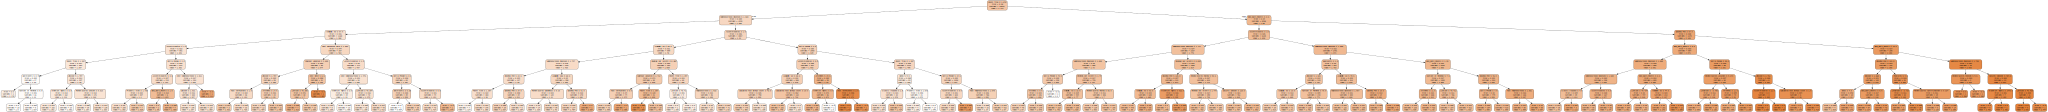

In [206]:
import graphviz

dot_data = tree.export_graphviz(treeModel, out_file=None, 
                         feature_names=feature_names, 
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph

Comparamos el árbol de decisión en función de su complejidad, profundidad. El resultado óptimo es 7 como se puede ver después de la validación cruzada. 
A medida que reducimos la profundidad simplificamos el modelo pero aumenta el error. En las siguientes gráficas se pueden comparar los errores para 5 y 3 de profundidad y además podemos visualizar el diagrama del árbol para profundidad 3. Es más sencillo que el óptimo, tiene más explicabilidad, pero el error es mayor.

![](img/ArbolDecis_profundidad.png)

![](img/arbolProf3.png)

Este otro no se visualiza muy bien

from sklearn import tree

tree.plot_tree(treeModel) 

### 2.3. Random Forest

El proceso es igual que en los modelos anteriores: separación X/y, validación cruzada, aplicación en test y comprobación de resultados.

In [239]:
from sklearn import preprocessing
data = filtered_df.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = cols[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  7.1min finished


best mean cross-validation score: 0.801
best parameters: {'max_depth': 19}


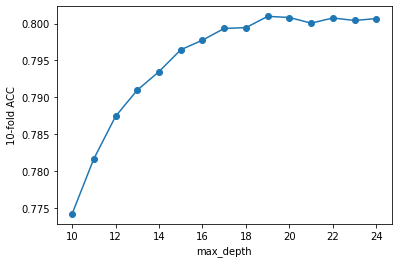

In [208]:
from sklearn.ensemble import RandomForestRegressor

maxDepth = range(10,25)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), 
                    param_grid=tuned_parameters,cv=10,verbose=1) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Nos apoyamos en la siguiente gráfica (muy similar a la de la ejecución), donde se ve que la profundidad óptima que marca es de 29. Sin embargo, viendo el valor de la accuracy tenemos prestaciones similares con una profundidad de 17, siendo este caso más sencillo.

![](img/RF_optDepth.png)

Ahora cargamos el conjunto de test, lo transformamos de la misma manera que hemos hecho con el de train y evaluamos los resultados

In [240]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# aplicarle LAS MISMAS transformaciones que hayáis hecho en train 
#filtro Madrid
indexNames = df_test[df_test['City'] != 'Madrid' ].index
df_test.drop(indexNames , inplace=True)
df_test.drop(['City'], axis=1, inplace=True)

#drop general
df_test.drop(['ID','Scrape ID','Last Scraped','Host ID','Calendar last Scraped','Listing Url','Thumbnail Url',
         'Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url',
        'Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access',
         'Interaction','House Rules','Host Name','Host About','Street','Host Location','State','Market',
         'Smart Location','Country Code','Country','Geolocation','Weekly Price','Monthly Price',
         'Host Acceptance Rate','Experiences Offered','Has Availability','License','Jurisdiction Names','Square Feet'], 
        axis=1, inplace=True)
#price
df_test['Price'].fillna(MeanPriceTrain, inplace=True)
Price_filter = df_test['Price'] <= 400
filtered_df_test = df_test[Price_filter]
filtered_df_test['Price'] = filtered_df_test['Price'].apply(lambda x: np.log10(x))

#fechas
filtered_df_test['Host Since'] = pd.to_datetime(filtered_df_test['Host Since'], format="%Y-%m-%d")
filtered_df_test['First Review'] = pd.to_datetime(filtered_df_test['First Review'], format="%Y-%m-%d")
filtered_df_test['Last Review'] = pd.to_datetime(filtered_df_test['Last Review'], format="%Y-%m-%d")
filtered_df_test['Host Since'] = filtered_df_test['Host Since'].apply(lambda x: 2017 - x.year)
filtered_df_test['First Review'] = filtered_df_test['First Review'].apply(lambda x: 2017 - x.year)
filtered_df_test['Last Review'] = filtered_df_test['Last Review'].apply(lambda x: 2017 - x.year)

#variables categóricas donde tomamos la moda para los valores que faltan.
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Host Since'].fillna(ModeHSTrain, inplace=True)
filtered_df_test['Host Listings Count'].fillna(ModeHLCTrain, inplace=True)
filtered_df_test['Host Total Listings Count'].fillna(ModeHTLCTrain, inplace=True)
filtered_df_test['Bathrooms'].fillna(ModeBathroomsTrain, inplace=True)
filtered_df_test['Bedrooms'].fillna(ModeBedroomsTrain, inplace=True)
filtered_df_test['Beds'].fillna(ModeBedsTrain, inplace=True)

#variables lineales donde tomamos la media para los valores que faltan
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Review Scores Rating'].fillna(MeanRSRatingTrain, inplace=True)
filtered_df_test['Review Scores Accuracy'].fillna(MeanRSAccuracy, inplace=True)
filtered_df_test['Review Scores Cleanliness'].fillna(MeanRSCleanliness, inplace=True)
filtered_df_test['Review Scores Checkin'].fillna(MeanRSCheckin, inplace=True)
filtered_df_test['Review Scores Communication'].fillna(MeanRSCommunication, inplace=True)
filtered_df_test['Review Scores Location'].fillna(MeanRSLocation, inplace=True)
filtered_df_test['Review Scores Value'].fillna(MeanRSValue, inplace=True)

#los vacíos los consideramos como desconocidos
filtered_df_test['Host Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Host Verifications'].fillna('Unknown', inplace=True)
filtered_df_test['Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Zipcode'].fillna('Unknown', inplace=True)
filtered_df_test['Amenities'].fillna('Unknown', inplace=True)
filtered_df_test['First Review'].fillna('Unknown', inplace=True)
filtered_df_test['Last Review'].fillna('Unknown', inplace=True)

#consideramos que donde falta un valor es porque no existe, es decir, no hay respuesta o la tasa es 0€
filtered_df_test['Host Response Time'].fillna('No response', inplace=True)
filtered_df_test['Host Response Rate'].fillna(0, inplace=True)
filtered_df_test['Security Deposit'].fillna(0, inplace=True)
filtered_df_test['Cleaning Fee'].fillna(0, inplace=True)
filtered_df_test['Reviews per Month'].fillna(0, inplace=True)

#transformaciones contando palabras. es algo muy sencillo, queda pendiente mejorarlo con técnicas NLP en el futuro
filtered_df_test['Amenities'] = filtered_df_test['Amenities'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Host Verifications'] = filtered_df_test['Host Verifications'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Features'] = filtered_df_test['Features'].apply(lambda x: len(str(x).split(',')))

# MeanEncoder
for c in categorical:
    filtered_df_test[c] = filtered_df_test[c].map(mean_map[c])

#creación nuevas variables
filtered_df_test['Bed_Bath_Rooms'] = filtered_df_test['Bedrooms']*filtered_df_test['Bathrooms']

#eliminamos vaiables con correlación muy alta
filtered_df_test.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 90'], 
        axis=1, inplace=True)

#colocamos la variable objetivo al principio
cols = filtered_df_test.columns.tolist()
cols = cols[19:20] + cols[0:19] + cols [20:]
filtered_df_test = filtered_df_test[cols]

#en los valores vacíos como la moda de train
filtered_df_test['Host Neighbourhood'].fillna(filtered_df['Host Neighbourhood'].mode()[0], inplace=True)
filtered_df_test['Zipcode'].fillna(filtered_df['Zipcode'].mode()[0], inplace=True)
filtered_df_test['Property Type'].fillna(filtered_df['Property Type'].mode()[0], inplace=True)
filtered_df_test['Calendar Updated'].fillna(filtered_df['Calendar Updated'].mode()[0], inplace=True)

data_test = filtered_df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = filtered_df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

In [241]:
from sklearn.metrics import mean_squared_error

maxDepthOptimo = grid.best_params_['max_depth']
RFModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",RFModel.score(X_train,y_train))
print("Test: ",RFModel.score(X_test,y_test))


ytrainRFModel = RFModel.predict(X_train)
ytestRFModel  = RFModel.predict(X_test)


#deshacemos la transformación logarítmica
ytrainRFModel = pd.DataFrame(ytrainRFModel).apply(lambda x: 10**(x))
ytestRFModel = pd.DataFrame(ytestRFModel).apply(lambda x: 10**(x))
y_train = pd.DataFrame(y_train).apply(lambda x: 10**(x))
y_test = pd.DataFrame(y_test).apply(lambda x: 10**(x))

#calculamos el MSE y el RMSE para train y test
mseTrainRFModel = mean_squared_error(y_train,ytrainRFModel)
mseTestRFModel = mean_squared_error(y_test,ytestRFModel)

print('MSE RF (train): %0.3g' % mseTrainRFModel)
print('MSE RF (test) : %0.3g' % mseTestRFModel)

print('RMSE RF (train): %0.3g' % np.sqrt(mseTrainRFModel))
print('RMSE RF (test) : %0.3g' % np.sqrt(mseTestRFModel))


Train:  0.9634144006084087
Test:  0.7851512774298861
MSE RF (train): 146
MSE RF (test) : 655
RMSE RF (train): 12.1
RMSE RF (test) : 25.6


Viendo los resultados observamos cómo el modelo ha aprendido muy bien los datos de train. Tenemos una accuracy y un RMSE mejor que los modelos anteriores: sobre el 95% y el error baja a los 12€ aprox. Sin embargo en el conjunto de test no son tan buenos.

Esto es una clara indicación de overfitting, por lo que para simplificar el modelo podemos optar por reducir la dimensionlidad (hay que recordar que seguimos trabajando con 44 variables de entrada) y decrecer la profundidad.

En el siguiente gráfico se puede ver cómo disminuyendo la profundidad va desapareciendo el overfitting aunque va aumentando el error en test.

![](img/RF_compDepth.png)

Ahora vamos a analizar la importancia de las variables de entrada:

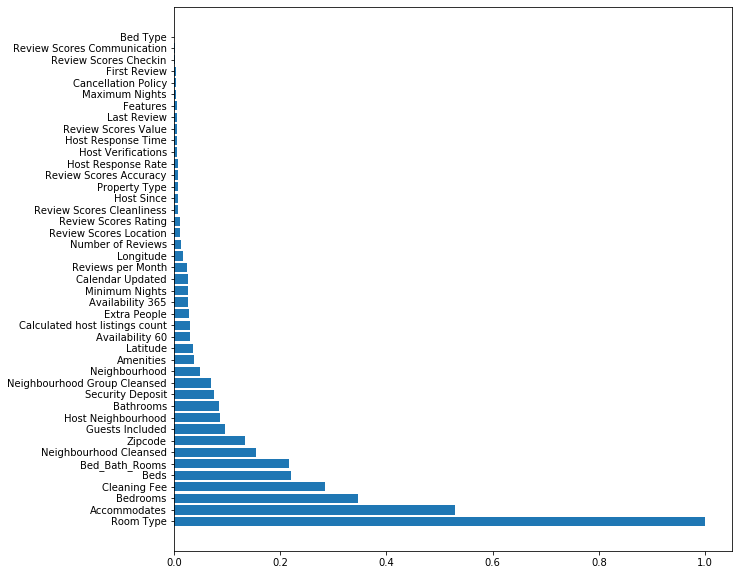

In [45]:
features = filtered_df.columns.drop(['Price'])

importances = RFModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

Viendo las importancias de las variables y con el objetivo de reducir la simplicidad del modelo vamos a quedarnos solo con las que consideramos más relevantes (las 13 primeras) y repetimos el proceso:

In [249]:
df_RandomForest=filtered_df.drop(features[indices][13:], axis=1)

print(df_RandomForest.shape)
df_RandomForest.head()

(10523, 14)


,Price,Host Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Zipcode,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Security Deposit,Cleaning Fee,Guests Included,Bed_Bath_Rooms
0,1.778151,1.777984,1.870709,1.715954,1.828019,1.879846,4,1.0,1.0,2.0,0.0,25.0,1,1.0
1,1.698970,1.650428,1.855905,1.779878,1.748494,1.879846,4,1.0,1.0,2.0,0.0,15.0,1,1.0
2,1.000000,1.504347,1.433458,1.480933,1.433262,1.321075,1,1.5,1.0,8.0,0.0,5.0,1,1.5
3,1.477121,1.738522,1.711917,1.779878,1.748494,1.472970,2,3.0,1.0,1.0,0.0,0.0,1,3.0
4,1.505150,1.610016,1.640189,1.752802,1.716663,1.472970,2,1.0,1.0,1.0,0.0,0.0,1,1.0


In [269]:
from sklearn import preprocessing

dataRF = df_RandomForest.values
y_train = dataRF[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = dataRF[:,1:]      # nos quedamos con el resto
feature_names = cols[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.9min finished


best mean cross-validation score: 0.751
best parameters: {'max_depth': 15}


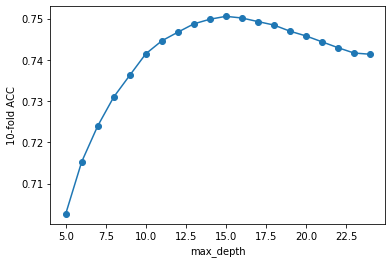

In [254]:
from sklearn.ensemble import RandomForestRegressor


maxDepth = range(5,25)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), 
                    param_grid=tuned_parameters,cv=10,verbose=1) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

De entrada se observa que el modelo es más eficiente computacionalmente hablando. Ha tardado menos tiempo com más entrenamientos.

Pasamos a evaluar los resultados en test.

In [270]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# aplicarle LAS MISMAS transformaciones que hayáis hecho en train 
#filtro Madrid
indexNames = df_test[df_test['City'] != 'Madrid' ].index
df_test.drop(indexNames , inplace=True)
df_test.drop(['City'], axis=1, inplace=True)

#drop general
df_test.drop(['ID','Scrape ID','Last Scraped','Host ID','Calendar last Scraped','Listing Url','Thumbnail Url',
         'Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url',
        'Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access',
         'Interaction','House Rules','Host Name','Host About','Street','Host Location','State','Market',
         'Smart Location','Country Code','Country','Geolocation','Weekly Price','Monthly Price',
         'Host Acceptance Rate','Experiences Offered','Has Availability','License','Jurisdiction Names','Square Feet'], 
        axis=1, inplace=True)

#price
df_test['Price'].fillna(MeanPriceTrain, inplace=True)
Price_filter = df_test['Price'] <= 400
filtered_df_test = df_test[Price_filter]
filtered_df_test['Price'] = filtered_df_test['Price'].apply(lambda x: np.log10(x))

#fechas
filtered_df_test['Host Since'] = pd.to_datetime(filtered_df_test['Host Since'], format="%Y-%m-%d")
filtered_df_test['First Review'] = pd.to_datetime(filtered_df_test['First Review'], format="%Y-%m-%d")
filtered_df_test['Last Review'] = pd.to_datetime(filtered_df_test['Last Review'], format="%Y-%m-%d")
filtered_df_test['Host Since'] = filtered_df_test['Host Since'].apply(lambda x: 2017 - x.year)
filtered_df_test['First Review'] = filtered_df_test['First Review'].apply(lambda x: 2017 - x.year)
filtered_df_test['Last Review'] = filtered_df_test['Last Review'].apply(lambda x: 2017 - x.year)

#variables categóricas donde tomamos la moda para los valores que faltan.
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Host Since'].fillna(ModeHSTrain, inplace=True)
filtered_df_test['Host Listings Count'].fillna(ModeHLCTrain, inplace=True)
filtered_df_test['Host Total Listings Count'].fillna(ModeHTLCTrain, inplace=True)
filtered_df_test['Bathrooms'].fillna(ModeBathroomsTrain, inplace=True)
filtered_df_test['Bedrooms'].fillna(ModeBedroomsTrain, inplace=True)
filtered_df_test['Beds'].fillna(ModeBedsTrain, inplace=True)

#variables lineales donde tomamos la media para los valores que faltan
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Review Scores Rating'].fillna(MeanRSRatingTrain, inplace=True)
filtered_df_test['Review Scores Accuracy'].fillna(MeanRSAccuracy, inplace=True)
filtered_df_test['Review Scores Cleanliness'].fillna(MeanRSCleanliness, inplace=True)
filtered_df_test['Review Scores Checkin'].fillna(MeanRSCheckin, inplace=True)
filtered_df_test['Review Scores Communication'].fillna(MeanRSCommunication, inplace=True)
filtered_df_test['Review Scores Location'].fillna(MeanRSLocation, inplace=True)
filtered_df_test['Review Scores Value'].fillna(MeanRSValue, inplace=True)

#los vacíos los consideramos como desconocidos
filtered_df_test['Host Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Host Verifications'].fillna('Unknown', inplace=True)
filtered_df_test['Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Zipcode'].fillna('Unknown', inplace=True)
filtered_df_test['Amenities'].fillna('Unknown', inplace=True)
filtered_df_test['First Review'].fillna('Unknown', inplace=True)
filtered_df_test['Last Review'].fillna('Unknown', inplace=True)

#consideramos que donde falta un valor es porque no existe, es decir, no hay respuesta o la tasa es 0€
filtered_df_test['Host Response Time'].fillna('No response', inplace=True)
filtered_df_test['Host Response Rate'].fillna(0, inplace=True)
filtered_df_test['Security Deposit'].fillna(0, inplace=True)
filtered_df_test['Cleaning Fee'].fillna(0, inplace=True)
filtered_df_test['Reviews per Month'].fillna(0, inplace=True)

#transformaciones contando palabras. es algo muy sencillo, queda pendiente mejorarlo con técnicas NLP en el futuro
filtered_df_test['Amenities'] = filtered_df_test['Amenities'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Host Verifications'] = filtered_df_test['Host Verifications'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Features'] = filtered_df_test['Features'].apply(lambda x: len(str(x).split(',')))

# MeanEncoder
for c in categorical:
    filtered_df_test[c] = filtered_df_test[c].map(mean_map[c])

#creación nuevas variables
filtered_df_test['Bed_Bath_Rooms'] = filtered_df_test['Bedrooms']*filtered_df_test['Bathrooms']

#eliminamos vaiables con correlación muy alta
filtered_df_test.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 90'], 
        axis=1, inplace=True)

#colocamos la variable objetivo al principio
cols = filtered_df_test.columns.tolist()
cols = cols[19:20] + cols[0:19] + cols [20:]
filtered_df_test = filtered_df_test[cols]

#en los valores vacíos como la moda de train
filtered_df_test['Host Neighbourhood'].fillna(filtered_df['Host Neighbourhood'].mode()[0], inplace=True)
filtered_df_test['Zipcode'].fillna(filtered_df['Zipcode'].mode()[0], inplace=True)
filtered_df_test['Property Type'].fillna(filtered_df['Property Type'].mode()[0], inplace=True)
filtered_df_test['Calendar Updated'].fillna(filtered_df['Calendar Updated'].mode()[0], inplace=True)

#eliminamos las variables de menor importancia según el modelo RF
filtered_df_test.drop(features[indices][13:], axis=1, inplace=True)

data_test = filtered_df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = filtered_df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

In [271]:
from sklearn.metrics import mean_squared_error

maxDepthOptimo = grid.best_params_['max_depth']-10
RFModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",RFModel.score(X_train,y_train))
print("Test: ",RFModel.score(X_test,y_test))


ytrainRFModel = RFModel.predict(X_train)
ytestRFModel  = RFModel.predict(X_test)


#deshacemos la transformación logarítmica
ytrainRFModel = pd.DataFrame(ytrainRFModel).apply(lambda x: 10**(x))
ytestRFModel = pd.DataFrame(ytestRFModel).apply(lambda x: 10**(x))
y_train = pd.DataFrame(y_train).apply(lambda x: 10**(x))
y_test = pd.DataFrame(y_test).apply(lambda x: 10**(x))

#calculamos el MSE y el RMSE para train y test
mseTrainRFModel = mean_squared_error(y_train,ytrainRFModel)
mseTestRFModel = mean_squared_error(y_test,ytestRFModel)

print('MSE RF simplificado (train): %0.3g' % mseTrainRFModel)
print('MSE RF simplificado (test) : %0.3g' % mseTestRFModel)

print('RMSE RF simplificado (train): %0.3g' % np.sqrt(mseTrainRFModel))
print('RMSE RF simplificado (test) : %0.3g' % np.sqrt(mseTestRFModel))


Train:  0.7118999917916357
Test:  0.6873603413628537
MSE RF simplificado (train): 879
MSE RF simplificado (test) : 915
RMSE RF simplificado (train): 29.6
RMSE RF simplificado (test) : 30.2


Para la profundidad óptima (15) seguimos teniendo overfitting.
A continuación podemos ver cómo varía el error del modelo en función de la profundidad:


![](img/RF_simplificado_compDepth.png)

### 2.4. Boosted Trees

De ahora en adelante vamos a tener en cuenta la reducción de dimensionalidad que se ha obtenido con el RF.

En este modelo hay que tener en cuenta 3 hiperparámetros para comprender lo que se está haciendo.

Por un lado tenemos la *profundidad del árbol*. Interesa que sea pequeña para que la capacidad de generalización sea mayor.

*Número de iteraciones*. Si es muy alto peligro de overfitting.

*Tasa de aprendizaje*. Está relacionado con el número de iteraciones. Si alpha es pequeño se necesitan más iteraciones para que las prestaciones converjan.


In [316]:
from sklearn import preprocessing

data = dataRF
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = cols[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

Esta validación cruzada es muy costosa porque habría que poner muchas variables a recorrer, por lo que debido a la falta de tiempo se va a hacer un poco a mano y de manera iterativa.

Fijo la profundidad a 7 y haciendo distintos barridos en la tasa de aprendizaje y el número de estimadores he llegado a los siguientes valores.

In [317]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500,600,700]
learningRate = [0.01,0.001]
# mantenemos max_depth estático: max_depth=7

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=7), param_grid=param_grid, cv = 5, verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. learning_rate=0.01, n_estimators=500, total=   8.3s
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ............. learning_rate=0.01, n_estimators=500, total=   8.1s
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV] ............. learning_rate=0.01, n_estimators=500, total=   8.1s
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV] ............. learning_rate=0.01, n_estimators=500, total=   8.3s
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV] ............. learning_rate=0.01, n_estimators=500, total=   8.4s
[CV] learning_rate=0.01, n_estimators=600 ............................
[CV] ............. learning_rate=0.01, n_estimators=600, total=   9.8s
[CV] learning_rate=0.01, n_estimators=600 ............................
[CV] ............. learning_rate=0.01, n_estimators=600, total=   9.4s
[CV] learning_rate=0.01, n_estimators=600 ............................
[CV] ............. learning_rate=0.01, n_estimators=600, total=   9.9s
[CV] learning_rate=0.01, n_estimators=600 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.1min finished


best mean cross-validation score: 0.744
best parameters: {'learning_rate': 0.01, 'n_estimators': 700}


In [318]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# aplicarle LAS MISMAS transformaciones que hayáis hecho en train 
#filtro Madrid
indexNames = df_test[df_test['City'] != 'Madrid' ].index
df_test.drop(indexNames , inplace=True)
df_test.drop(['City'], axis=1, inplace=True)

#drop general
df_test.drop(['ID','Scrape ID','Last Scraped','Host ID','Calendar last Scraped','Listing Url','Thumbnail Url',
         'Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url',
        'Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access',
         'Interaction','House Rules','Host Name','Host About','Street','Host Location','State','Market',
         'Smart Location','Country Code','Country','Geolocation','Weekly Price','Monthly Price',
         'Host Acceptance Rate','Experiences Offered','Has Availability','License','Jurisdiction Names','Square Feet'], 
        axis=1, inplace=True)

#price
df_test['Price'].fillna(MeanPriceTrain, inplace=True)
Price_filter = df_test['Price'] <= 400
filtered_df_test = df_test[Price_filter]
filtered_df_test['Price'] = filtered_df_test['Price'].apply(lambda x: np.log10(x))

#fechas
filtered_df_test['Host Since'] = pd.to_datetime(filtered_df_test['Host Since'], format="%Y-%m-%d")
filtered_df_test['First Review'] = pd.to_datetime(filtered_df_test['First Review'], format="%Y-%m-%d")
filtered_df_test['Last Review'] = pd.to_datetime(filtered_df_test['Last Review'], format="%Y-%m-%d")
filtered_df_test['Host Since'] = filtered_df_test['Host Since'].apply(lambda x: 2017 - x.year)
filtered_df_test['First Review'] = filtered_df_test['First Review'].apply(lambda x: 2017 - x.year)
filtered_df_test['Last Review'] = filtered_df_test['Last Review'].apply(lambda x: 2017 - x.year)

#variables categóricas donde tomamos la moda para los valores que faltan.
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Host Since'].fillna(ModeHSTrain, inplace=True)
filtered_df_test['Host Listings Count'].fillna(ModeHLCTrain, inplace=True)
filtered_df_test['Host Total Listings Count'].fillna(ModeHTLCTrain, inplace=True)
filtered_df_test['Bathrooms'].fillna(ModeBathroomsTrain, inplace=True)
filtered_df_test['Bedrooms'].fillna(ModeBedroomsTrain, inplace=True)
filtered_df_test['Beds'].fillna(ModeBedsTrain, inplace=True)

#variables lineales donde tomamos la media para los valores que faltan
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Review Scores Rating'].fillna(MeanRSRatingTrain, inplace=True)
filtered_df_test['Review Scores Accuracy'].fillna(MeanRSAccuracy, inplace=True)
filtered_df_test['Review Scores Cleanliness'].fillna(MeanRSCleanliness, inplace=True)
filtered_df_test['Review Scores Checkin'].fillna(MeanRSCheckin, inplace=True)
filtered_df_test['Review Scores Communication'].fillna(MeanRSCommunication, inplace=True)
filtered_df_test['Review Scores Location'].fillna(MeanRSLocation, inplace=True)
filtered_df_test['Review Scores Value'].fillna(MeanRSValue, inplace=True)

#los vacíos los consideramos como desconocidos
filtered_df_test['Host Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Host Verifications'].fillna('Unknown', inplace=True)
filtered_df_test['Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Zipcode'].fillna('Unknown', inplace=True)
filtered_df_test['Amenities'].fillna('Unknown', inplace=True)
filtered_df_test['First Review'].fillna('Unknown', inplace=True)
filtered_df_test['Last Review'].fillna('Unknown', inplace=True)

#consideramos que donde falta un valor es porque no existe, es decir, no hay respuesta o la tasa es 0€
filtered_df_test['Host Response Time'].fillna('No response', inplace=True)
filtered_df_test['Host Response Rate'].fillna(0, inplace=True)
filtered_df_test['Security Deposit'].fillna(0, inplace=True)
filtered_df_test['Cleaning Fee'].fillna(0, inplace=True)
filtered_df_test['Reviews per Month'].fillna(0, inplace=True)

#transformaciones contando palabras. es algo muy sencillo, queda pendiente mejorarlo con técnicas NLP en el futuro
filtered_df_test['Amenities'] = filtered_df_test['Amenities'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Host Verifications'] = filtered_df_test['Host Verifications'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Features'] = filtered_df_test['Features'].apply(lambda x: len(str(x).split(',')))

# MeanEncoder
for c in categorical:
    filtered_df_test[c] = filtered_df_test[c].map(mean_map[c])

#creación nuevas variables
filtered_df_test['Bed_Bath_Rooms'] = filtered_df_test['Bedrooms']*filtered_df_test['Bathrooms']

#eliminamos vaiables con correlación muy alta
filtered_df_test.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 90'], 
        axis=1, inplace=True)

#colocamos la variable objetivo al principio
cols = filtered_df_test.columns.tolist()
cols = cols[19:20] + cols[0:19] + cols [20:]
filtered_df_test = filtered_df_test[cols]

#en los valores vacíos como la moda de train
filtered_df_test['Host Neighbourhood'].fillna(filtered_df['Host Neighbourhood'].mode()[0], inplace=True)
filtered_df_test['Zipcode'].fillna(filtered_df['Zipcode'].mode()[0], inplace=True)
filtered_df_test['Property Type'].fillna(filtered_df['Property Type'].mode()[0], inplace=True)
filtered_df_test['Calendar Updated'].fillna(filtered_df['Calendar Updated'].mode()[0], inplace=True)

#eliminamos las variables de menor importancia según el modelo RF
filtered_df_test.drop(features[indices][13:], axis=1, inplace=True)


data_test = filtered_df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = filtered_df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

In [319]:
from sklearn.metrics import mean_squared_error

maxDepthOptimo = 7
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=maxDepthOptimo,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

print("Train: ",bt.score(X_train,y_train))
print("Test: ",bt.score(X_test,y_test))


ytrainBTModel = bt.predict(X_train)
ytestBTModel  = bt.predict(X_test)


#deshacemos la transformación logarítmica
ytrainBTModel = pd.DataFrame(ytrainBTModel).apply(lambda x: 10**(x))
ytestBTModel = pd.DataFrame(ytestBTModel).apply(lambda x: 10**(x))
y_train = pd.DataFrame(y_train).apply(lambda x: 10**(x))
y_test = pd.DataFrame(y_test).apply(lambda x: 10**(x))

#calculamos el MSE y el RMSE para train y test
mseTrainBTModel = mean_squared_error(y_train,ytrainBTModel)
mseTestBTModel = mean_squared_error(y_test,ytestBTModel)

print('MSE BT model (train): %0.3g' % mseTrainBTModel)
print('MSE BT model (test) : %0.3g' % mseTestBTModel)

print('RMSE BT model (train): %0.3g' % np.sqrt(mseTrainBTModel))
print('RMSE BT model (test) : %0.3g' % np.sqrt(mseTestBTModel))

Train:  0.8318336936634041
Test:  0.7317006108630085
MSE BT model (train): 411
MSE BT model (test) : 698
RMSE BT model (train): 20.3
RMSE BT model (test) : 26.4


Habría que seguir profundizando un poco con este modelo y ver si bajando la profundidad del árbol se reduce el overfitting que parece que existe.

### 2.5. SVR

Para este modelo también partimos de la reducción de dimensionalidad que obtuvimos con Random Forest.

Cosas importantes a tener en cuenta con el modelo Support Vector Machine: se concibió originalmente para problemas de clasificación, pero se ha extendido también a regresión. De ahí el nombre Suppor Vector Regression (SVR).

Se define como un clasificador lineal de máximo margen, por lo que trabaja con distancias y de ahí que sea muy imporante el escalado de los datos de entrada.

En este caso vamos a trabajar con el kernel RBF, que se considera universal ya que es capaz de aprender "cualquier cosa".

In [328]:
from sklearn import preprocessing

data = dataRF
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = cols[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  7.4min finished


best mean cross-validation score: 0.723
best parameters: {'C': 100.0, 'gamma': 0.002154434690031882}


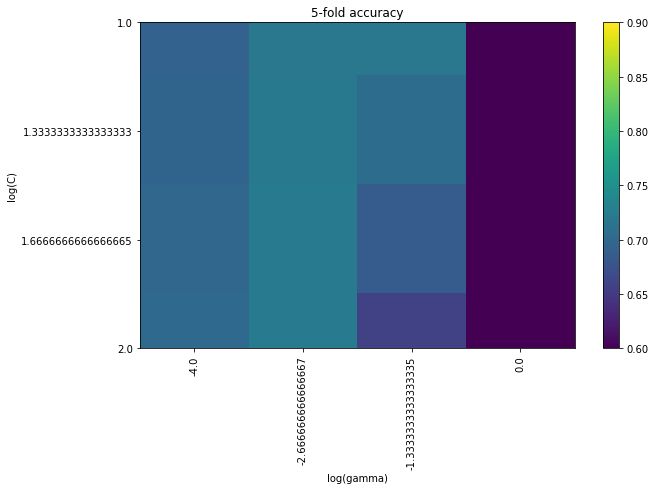

In [329]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Paso 2:
vectorC = np.logspace(1, 2, 4)
vectorG = np.logspace(-4, 0, 4)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=1)
grid.fit(XtrainScaled, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

In [330]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# aplicarle LAS MISMAS transformaciones que hayáis hecho en train 
#filtro Madrid
indexNames = df_test[df_test['City'] != 'Madrid' ].index
df_test.drop(indexNames , inplace=True)
df_test.drop(['City'], axis=1, inplace=True)

#drop general
df_test.drop(['ID','Scrape ID','Last Scraped','Host ID','Calendar last Scraped','Listing Url','Thumbnail Url',
         'Medium Url','Picture Url','XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url',
        'Name','Summary','Space','Description','Neighborhood Overview','Notes','Transit','Access',
         'Interaction','House Rules','Host Name','Host About','Street','Host Location','State','Market',
         'Smart Location','Country Code','Country','Geolocation','Weekly Price','Monthly Price',
         'Host Acceptance Rate','Experiences Offered','Has Availability','License','Jurisdiction Names','Square Feet'], 
        axis=1, inplace=True)

#price
df_test['Price'].fillna(MeanPriceTrain, inplace=True)
Price_filter = df_test['Price'] <= 400
filtered_df_test = df_test[Price_filter]
filtered_df_test['Price'] = filtered_df_test['Price'].apply(lambda x: np.log10(x))

#fechas
filtered_df_test['Host Since'] = pd.to_datetime(filtered_df_test['Host Since'], format="%Y-%m-%d")
filtered_df_test['First Review'] = pd.to_datetime(filtered_df_test['First Review'], format="%Y-%m-%d")
filtered_df_test['Last Review'] = pd.to_datetime(filtered_df_test['Last Review'], format="%Y-%m-%d")
filtered_df_test['Host Since'] = filtered_df_test['Host Since'].apply(lambda x: 2017 - x.year)
filtered_df_test['First Review'] = filtered_df_test['First Review'].apply(lambda x: 2017 - x.year)
filtered_df_test['Last Review'] = filtered_df_test['Last Review'].apply(lambda x: 2017 - x.year)

#variables categóricas donde tomamos la moda para los valores que faltan.
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Host Since'].fillna(ModeHSTrain, inplace=True)
filtered_df_test['Host Listings Count'].fillna(ModeHLCTrain, inplace=True)
filtered_df_test['Host Total Listings Count'].fillna(ModeHTLCTrain, inplace=True)
filtered_df_test['Bathrooms'].fillna(ModeBathroomsTrain, inplace=True)
filtered_df_test['Bedrooms'].fillna(ModeBedroomsTrain, inplace=True)
filtered_df_test['Beds'].fillna(ModeBedsTrain, inplace=True)

#variables lineales donde tomamos la media para los valores que faltan
#Lo extraemos en una variable disinta para cada columna con la intención de aplicar el mismo valor en test
filtered_df_test['Review Scores Rating'].fillna(MeanRSRatingTrain, inplace=True)
filtered_df_test['Review Scores Accuracy'].fillna(MeanRSAccuracy, inplace=True)
filtered_df_test['Review Scores Cleanliness'].fillna(MeanRSCleanliness, inplace=True)
filtered_df_test['Review Scores Checkin'].fillna(MeanRSCheckin, inplace=True)
filtered_df_test['Review Scores Communication'].fillna(MeanRSCommunication, inplace=True)
filtered_df_test['Review Scores Location'].fillna(MeanRSLocation, inplace=True)
filtered_df_test['Review Scores Value'].fillna(MeanRSValue, inplace=True)

#los vacíos los consideramos como desconocidos
filtered_df_test['Host Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Host Verifications'].fillna('Unknown', inplace=True)
filtered_df_test['Neighbourhood'].fillna('Unknown', inplace=True)
filtered_df_test['Zipcode'].fillna('Unknown', inplace=True)
filtered_df_test['Amenities'].fillna('Unknown', inplace=True)
filtered_df_test['First Review'].fillna('Unknown', inplace=True)
filtered_df_test['Last Review'].fillna('Unknown', inplace=True)

#consideramos que donde falta un valor es porque no existe, es decir, no hay respuesta o la tasa es 0€
filtered_df_test['Host Response Time'].fillna('No response', inplace=True)
filtered_df_test['Host Response Rate'].fillna(0, inplace=True)
filtered_df_test['Security Deposit'].fillna(0, inplace=True)
filtered_df_test['Cleaning Fee'].fillna(0, inplace=True)
filtered_df_test['Reviews per Month'].fillna(0, inplace=True)

#transformaciones contando palabras. es algo muy sencillo, queda pendiente mejorarlo con técnicas NLP en el futuro
filtered_df_test['Amenities'] = filtered_df_test['Amenities'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Host Verifications'] = filtered_df_test['Host Verifications'].apply(lambda x: len(str(x).split(',')))
filtered_df_test['Features'] = filtered_df_test['Features'].apply(lambda x: len(str(x).split(',')))

# MeanEncoder
for c in categorical:
    filtered_df_test[c] = filtered_df_test[c].map(mean_map[c])

#creación nuevas variables
filtered_df_test['Bed_Bath_Rooms'] = filtered_df_test['Bedrooms']*filtered_df_test['Bathrooms']

#eliminamos vaiables con correlación muy alta
filtered_df_test.drop(['Host Listings Count','Host Total Listings Count','Availability 30','Availability 90'], 
        axis=1, inplace=True)

#colocamos la variable objetivo al principio
cols = filtered_df_test.columns.tolist()
cols = cols[19:20] + cols[0:19] + cols [20:]
filtered_df_test = filtered_df_test[cols]

#en los valores vacíos como la moda de train
filtered_df_test['Host Neighbourhood'].fillna(filtered_df['Host Neighbourhood'].mode()[0], inplace=True)
filtered_df_test['Zipcode'].fillna(filtered_df['Zipcode'].mode()[0], inplace=True)
filtered_df_test['Property Type'].fillna(filtered_df['Property Type'].mode()[0], inplace=True)
filtered_df_test['Calendar Updated'].fillna(filtered_df['Calendar Updated'].mode()[0], inplace=True)

#eliminamos las variables de menor importancia según el modelo RF
filtered_df_test.drop(features[indices][13:], axis=1, inplace=True)

data_test = filtered_df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = filtered_df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

In [331]:
from sklearn.metrics import mean_squared_error


Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svrModel = SVR(kernel='rbf',gamma = Gopt, C = Copt).fit(XtrainScaled,y_train)

print('Acc (TRAIN): %0.2f'%svrModel.score(XtrainScaled,y_train))
print('Acc (TEST): %0.2f'%svrModel.score(XtestScaled,y_test))

ytrainSVRModel = svrModel.predict(XtrainScaled)
ytestSVRModel  = svrModel.predict(XtestScaled)


#deshacemos la transformación logarítmica
ytrainSVRModel = pd.DataFrame(ytrainSVRModel).apply(lambda x: 10**(x))
ytestSVRModel = pd.DataFrame(ytestSVRModel).apply(lambda x: 10**(x))
y_train = pd.DataFrame(y_train).apply(lambda x: 10**(x))
y_test = pd.DataFrame(y_test).apply(lambda x: 10**(x))

#calculamos el MSE y el RMSE para train y test
mseTrainSVRModel = mean_squared_error(y_train,ytrainSVRModel)
mseTestSVRModel = mean_squared_error(y_test,ytestSVRModel)

print('MSE SVR (train): %0.3g' % mseTrainSVRModel)
print('MSE SVR (test) : %0.3g' % mseTestSVRModel)

print('RMSE SVR (train): %0.3g' % np.sqrt(mseTrainSVRModel))
print('RMSE SVR (test) : %0.3g' % np.sqrt(mseTestSVRModel))



Acc (TRAIN): 0.74
Acc (TEST): 0.71
MSE SVR (train): 692
MSE SVR (test) : 799
RMSE SVR (train): 26.3
RMSE SVR (test) : 28.3


Habría que hacer un barrido más extenso para obtener unos hiperparámetros más optimizados, pero es un modelo que requiere mucho esfuerzo computacional. No obstante con las aproximaciones que he hecho hemos alcanzado unos resultados muy alienados con los obtenidos hasta ahora.

## 3. CONCLUSIÓN

La verdad que no se han obtenido resultados muy buenos en la predicción. Los errores suelen estar entre 25 y 30€, y hay que tener en cuenta que el valor medio del precio del dataset de partida eran 66€.

Modelos como el de Boosted Trees o el SVR nos dan cierto margen para poder optimizarlos un poco más, pero en vista de los resultados obtenidos algún modelo más sencillo como Random Forest sería buena opción.

De todas formas, para mejorar las prestaciones de nuestros modelos se aconseja trabajar con los datos de entrada. En concreto hay dos vías a considerar: aumentar el dataset (en este caso dependemos de airbnb) e incrementar las features de interés. En este segundo caso se me ocurren cosas como:
- utilizar técnicas NLP para extraer información de interés de campos descriptivos. En esta práctica se borraron directamente o se han usado de una manera tan simple que apenas aportan valor (por ejemplo, no es lo mismo contar el número de características de una propiedad que darlas valor en función de la calidad o importancia de cada una de ellas).
- utilizar técnicas de tratamiento de imagen para sacar información de las imágenes que existen en el dataset de entrada.
- añadir información al dataset como puede ser la distancia a sitios de interés, valoración de la ubicación según las opciones de transporte público disponibles, etc...
